In [2]:
import numpy as np
import pandas as pd

import os
import random

import warnings

warnings.filterwarnings(action='ignore')

path = '/opt/ml/input/data/'
dat = pd.read_csv(path + 'FE_total_2_elo2.csv')


In [3]:
dat.drop(['day','year','KnowledgeTag', 'last_answerCode7','last_answerCode8','last_answerCode9','last_answerCode10'], axis = 1, inplace = True)

In [4]:
_train = dat[dat['answerCode'] >= 0]
_test = dat[dat['answerCode'] < 0]

In [5]:
# valid 제작하는 함수 새로 개편.
# 예전 valid 제작 함수는 1분 걸렸는데 0.6초만에 끗~
_train['train_valid'] = 0
_train.loc[_train.drop_duplicates(subset='userID', keep = 'last').index, 'train_valid'] = -1
_valid = _train[_train['train_valid'] == -1]
_train = _train[_train['train_valid'] == 0]

In [6]:
# 모델에 적용하기 전 기본적인 데이터 전처리 부분
## 라벨링, 필요없는 칼럼 제거
_train_value = _train['answerCode']
_train.drop(['Timestamp', 'testId', 'train_valid', 'answerCode'], axis = 1, inplace = True) # ,'category_st_qcut_5'

_valid_value = _valid['answerCode']
_valid.drop(['Timestamp', 'testId', 'train_valid', 'answerCode'], axis = 1, inplace = True) # ,'category_st_qcut_5'

_test.drop(['Timestamp', 'testId', 'answerCode'], axis = 1, inplace = True) # ,'category_st_qcut_5'

In [7]:
# CatBoost에 적용하기 위해선 문자열 데이터로 변환 필요.
# 만약 범주형이 아니고 연속형(정수, 소수) 성질을 살리고 싶은 변수는 여기 drop에 적어두면 됨.(solve_time 같이.)
cat_columns = list(_train.drop(['solve_time','month', 'elouser', 'eloitem', 'elotag', 'elotest', 'elo',],axis=1).columns)

for col in cat_columns:
    _train[col] = _train[col].astype('str')
    _valid[col] = _valid[col].astype('str')
    _test[col] = _test[col].astype('str')

In [24]:
#!pip install optuna
#!pip install catboost
import gc
from sklearn.metrics import accuracy_score, roc_auc_score
from optuna import Trial, visualization
from optuna.samplers import TPESampler
from catboost import CatBoostClassifier
def objective(trial, FEATURE, train, valid, test, train_value, valid_value):
    
    # param = {
    # "task_type" : "GPU",
    # "eval_metric" : 'AUC',
    # "devices" : '0',
    # 'random_state' : 20221208,
    # 'learning_rate': 0.08,#trial.suggest_loguniform('learning_rate', 0.01, 0.05),
    # 'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 1),
    # 'iterations': 500, #trial.suggest_int("iterations", 500, 2000),
    # 'max_depth': 11,
    # 'random_strength': trial.suggest_int("random_strength", 5, 100),
    # 'l2_leaf_reg': trial.suggest_float("l2_leaf_reg",1e-8,3e-5),
    # #"colsample_bylevel":trial.suggest_float("colsample_bylevel", 0.4, 1.0),
    # 'min_child_samples': trial.suggest_int("min_child_samples", 5, 100), 
    # 'max_bin': trial.suggest_int("max_bin", 200, 500), 
    # 'od_type': 'Iter',
    # "cat_features" : FEATURE,
    # }
    
    param = {
    "task_type" : "GPU",
    "eval_metric" : 'AUC',
    "devices" : '0',
    'random_state' : 19991028,
    'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),
    'iterations': 9000,
    'max_depth': 11,
    'od_type': 'Iter',
    "cat_features" : cat_columns,
    'bagging_temperature': 0.36391590193742546, 
    'random_strength': 9, 
    'l2_leaf_reg': 6.803149112111853e-06, 
    'min_child_samples': 93, 
    'max_bin': 237
    }
    
    model = CatBoostClassifier(**param)
    model.fit(train, train_value, early_stopping_rounds=100, verbose=10, eval_set=(_valid, _valid_value))
    
    # print('train score')
    # train_pred = model.predict_proba(train[FEATURE])[:,1]
    # print(roc_auc_score(train_value, train_pred)) # auc
    # print(accuracy_score(train_value, np.where(train_pred >= 0.5, 1, 0))) # acc, 정확도

    # print('valid score')
    valid_pred = model.predict_proba(valid)[:,1]
    # print(roc_auc_score(valid_value, valid_pred)) # auc
    # print(accuracy_score(valid_value, np.where(valid_pred >= 0.5, 1, 0))) # acc, 정확도

    return roc_auc_score(valid_value, valid_pred)

In [25]:
import optuna
sampler = optuna.samplers.TPESampler(seed=20221208)
study = optuna.create_study(
    study_name = 'cat_parameter_opt',
    direction = 'maximize',
    sampler = sampler,
)
study.optimize(lambda trial : objective(trial, cat_columns, _train, _valid, _test, _train_value, _valid_value), n_trials=100)

[I 2022-12-08 02:27:54,496] A new study created in memory with name: cat_parameter_opt
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8025632	best: 0.8025632 (0)	total: 308ms	remaining: 46m 13s
10:	test: 0.8111976	best: 0.8112175 (9)	total: 3.32s	remaining: 45m 10s
20:	test: 0.8153531	best: 0.8153531 (20)	total: 6.04s	remaining: 43m 3s
30:	test: 0.8166414	best: 0.8166414 (30)	total: 8.84s	remaining: 42m 36s
40:	test: 0.8195817	best: 0.8195817 (40)	total: 11.5s	remaining: 42m 3s
50:	test: 0.8214007	best: 0.8215922 (49)	total: 14.2s	remaining: 41m 37s
60:	test: 0.8230669	best: 0.8231415 (59)	total: 17.1s	remaining: 41m 41s
70:	test: 0.8244496	best: 0.8244496 (70)	total: 19.8s	remaining: 41m 25s
80:	test: 0.8256727	best: 0.8256727 (80)	total: 22.3s	remaining: 40m 54s
90:	test: 0.8269102	best: 0.8269102 (90)	total: 25.1s	remaining: 41m
100:	test: 0.8281027	best: 0.8281027 (100)	total: 27.5s	remaining: 40m 19s
110:	test: 0.8291290	best: 0.8291290 (110)	total: 30.1s	remaining: 40m 13s
120:	test: 0.8297837	best: 0.8297837 (120)	total: 32.8s	remaining: 40m 9s
130:	test: 0.8302177	best: 0.8302177 (130)	total: 35.2s

[I 2022-12-08 02:33:18,726] Trial 0 finished with value: 0.8390561152010926 and parameters: {'learning_rate': 0.025468007296244984}. Best is trial 0 with value: 0.8390561152010926.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8025632	best: 0.8025632 (0)	total: 295ms	remaining: 44m 14s
10:	test: 0.8100979	best: 0.8120511 (9)	total: 3.26s	remaining: 44m 22s
20:	test: 0.8132922	best: 0.8132922 (20)	total: 6.13s	remaining: 43m 41s
30:	test: 0.8152665	best: 0.8152665 (30)	total: 8.94s	remaining: 43m 6s
40:	test: 0.8163536	best: 0.8163536 (40)	total: 11.8s	remaining: 42m 51s
50:	test: 0.8175571	best: 0.8175571 (50)	total: 14.4s	remaining: 41m 59s
60:	test: 0.8190261	best: 0.8190261 (60)	total: 17.1s	remaining: 41m 52s
70:	test: 0.8202632	best: 0.8202632 (70)	total: 19.9s	remaining: 41m 41s
80:	test: 0.8214474	best: 0.8214474 (80)	total: 22.7s	remaining: 41m 38s
90:	test: 0.8224468	best: 0.8224468 (90)	total: 25.4s	remaining: 41m 27s
100:	test: 0.8234569	best: 0.8234569 (100)	total: 28.1s	remaining: 41m 18s
110:	test: 0.8242655	best: 0.8242655 (110)	total: 30.8s	remaining: 41m 4s
120:	test: 0.8249153	best: 0.8249153 (120)	total: 33.5s	remaining: 41m 1s
130:	test: 0.8259612	best: 0.8259612 (130)	total: 3

[I 2022-12-08 02:41:30,912] Trial 1 finished with value: 0.8395340044743214 and parameters: {'learning_rate': 0.014708996842613502}. Best is trial 1 with value: 0.8395340044743214.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8025632	best: 0.8025632 (0)	total: 293ms	remaining: 43m 59s
10:	test: 0.8114538	best: 0.8115776 (9)	total: 3.22s	remaining: 43m 49s
20:	test: 0.8149183	best: 0.8149183 (20)	total: 6.03s	remaining: 42m 59s
30:	test: 0.8174183	best: 0.8174183 (30)	total: 9s	remaining: 43m 23s
40:	test: 0.8205133	best: 0.8205133 (40)	total: 11.9s	remaining: 43m 10s
50:	test: 0.8222606	best: 0.8222606 (50)	total: 14.7s	remaining: 42m 55s
60:	test: 0.8238738	best: 0.8238738 (60)	total: 17.3s	remaining: 42m 21s
70:	test: 0.8256058	best: 0.8256058 (70)	total: 20.1s	remaining: 42m 12s
80:	test: 0.8265136	best: 0.8265411 (79)	total: 22.8s	remaining: 41m 50s
90:	test: 0.8277377	best: 0.8277377 (90)	total: 25.5s	remaining: 41m 39s
100:	test: 0.8281391	best: 0.8281806 (98)	total: 27.9s	remaining: 40m 56s
110:	test: 0.8287896	best: 0.8287896 (110)	total: 30.6s	remaining: 40m 52s
120:	test: 0.8293989	best: 0.8293989 (120)	total: 33.4s	remaining: 40m 52s
130:	test: 0.8299125	best: 0.8299125 (130)	total: 36

[I 2022-12-08 02:47:18,360] Trial 2 finished with value: 0.8394713411349553 and parameters: {'learning_rate': 0.025022021480599427}. Best is trial 1 with value: 0.8395340044743214.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8025632	best: 0.8025632 (0)	total: 290ms	remaining: 43m 32s
10:	test: 0.8122067	best: 0.8122067 (10)	total: 3.1s	remaining: 42m 15s
20:	test: 0.8153302	best: 0.8153302 (20)	total: 5.91s	remaining: 42m 6s
30:	test: 0.8174176	best: 0.8174176 (30)	total: 8.63s	remaining: 41m 36s
40:	test: 0.8193168	best: 0.8193168 (40)	total: 11.4s	remaining: 41m 31s
50:	test: 0.8204152	best: 0.8205806 (49)	total: 14s	remaining: 41m 2s
60:	test: 0.8222215	best: 0.8222215 (60)	total: 16.9s	remaining: 41m 18s
70:	test: 0.8240436	best: 0.8240436 (70)	total: 19.5s	remaining: 40m 57s
80:	test: 0.8247307	best: 0.8247307 (80)	total: 22.3s	remaining: 40m 56s
90:	test: 0.8260669	best: 0.8260669 (90)	total: 25.1s	remaining: 40m 54s
100:	test: 0.8270761	best: 0.8270761 (100)	total: 27.6s	remaining: 40m 34s
110:	test: 0.8279456	best: 0.8279456 (110)	total: 30.2s	remaining: 40m 19s
120:	test: 0.8289311	best: 0.8289311 (120)	total: 33s	remaining: 40m 20s
130:	test: 0.8296050	best: 0.8296050 (130)	total: 35.6

[I 2022-12-08 02:53:09,838] Trial 3 finished with value: 0.839635335502916 and parameters: {'learning_rate': 0.0220518736907076}. Best is trial 3 with value: 0.839635335502916.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8025632	best: 0.8025632 (0)	total: 295ms	remaining: 44m 18s
10:	test: 0.8146805	best: 0.8146805 (10)	total: 3.22s	remaining: 43m 55s
20:	test: 0.8186098	best: 0.8186098 (20)	total: 6.05s	remaining: 43m 6s
30:	test: 0.8211007	best: 0.8211007 (30)	total: 8.87s	remaining: 42m 46s
40:	test: 0.8240193	best: 0.8240193 (40)	total: 11.6s	remaining: 42m 7s
50:	test: 0.8251232	best: 0.8251232 (50)	total: 14.4s	remaining: 42m 4s
60:	test: 0.8259482	best: 0.8267674 (57)	total: 17.1s	remaining: 41m 39s
70:	test: 0.8274145	best: 0.8274145 (70)	total: 19.7s	remaining: 41m 20s
80:	test: 0.8282416	best: 0.8282503 (79)	total: 22.1s	remaining: 40m 37s
90:	test: 0.8296104	best: 0.8296104 (90)	total: 24.9s	remaining: 40m 41s
100:	test: 0.8305319	best: 0.8305319 (100)	total: 27.5s	remaining: 40m 24s
110:	test: 0.8309994	best: 0.8309994 (110)	total: 30.1s	remaining: 40m 10s
120:	test: 0.8315214	best: 0.8315214 (120)	total: 32.8s	remaining: 40m 7s
130:	test: 0.8318476	best: 0.8318495 (126)	total: 3

[I 2022-12-08 02:57:04,464] Trial 4 finished with value: 0.8376146415675058 and parameters: {'learning_rate': 0.03699748574934729}. Best is trial 3 with value: 0.839635335502916.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8025632	best: 0.8025632 (0)	total: 293ms	remaining: 43m 57s
10:	test: 0.8112299	best: 0.8112943 (9)	total: 3.27s	remaining: 44m 35s
20:	test: 0.8160525	best: 0.8160525 (20)	total: 6.22s	remaining: 44m 20s
30:	test: 0.8181167	best: 0.8181167 (30)	total: 9.08s	remaining: 43m 46s
40:	test: 0.8206445	best: 0.8206445 (40)	total: 12s	remaining: 43m 41s
50:	test: 0.8225746	best: 0.8225746 (50)	total: 14.8s	remaining: 43m 20s
60:	test: 0.8240663	best: 0.8240663 (60)	total: 17.4s	remaining: 42m 36s
70:	test: 0.8257838	best: 0.8257838 (70)	total: 20.3s	remaining: 42m 32s
80:	test: 0.8264059	best: 0.8264059 (80)	total: 22.8s	remaining: 41m 53s
90:	test: 0.8274432	best: 0.8274432 (90)	total: 25.6s	remaining: 41m 48s
100:	test: 0.8282454	best: 0.8283505 (99)	total: 28.2s	remaining: 41m 28s
110:	test: 0.8290555	best: 0.8290555 (110)	total: 30.8s	remaining: 41m 2s
120:	test: 0.8297952	best: 0.8297952 (120)	total: 33.2s	remaining: 40m 32s
130:	test: 0.8305126	best: 0.8305126 (130)	total: 35

[I 2022-12-08 03:02:20,111] Trial 5 finished with value: 0.8374452987715022 and parameters: {'learning_rate': 0.025588559053368615}. Best is trial 3 with value: 0.839635335502916.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8025632	best: 0.8025632 (0)	total: 300ms	remaining: 44m 56s
10:	test: 0.8083443	best: 0.8142763 (8)	total: 3.17s	remaining: 43m 12s
20:	test: 0.8150778	best: 0.8150778 (20)	total: 6.01s	remaining: 42m 48s
30:	test: 0.8198324	best: 0.8198324 (30)	total: 8.67s	remaining: 41m 48s
40:	test: 0.8224579	best: 0.8224579 (40)	total: 11.4s	remaining: 41m 29s
50:	test: 0.8244211	best: 0.8244211 (50)	total: 14.2s	remaining: 41m 22s
60:	test: 0.8262856	best: 0.8262856 (60)	total: 16.8s	remaining: 40m 54s
70:	test: 0.8276342	best: 0.8276342 (70)	total: 19.4s	remaining: 40m 41s
80:	test: 0.8284568	best: 0.8284568 (80)	total: 21.9s	remaining: 40m 13s
90:	test: 0.8295072	best: 0.8295072 (90)	total: 24.5s	remaining: 39m 56s
100:	test: 0.8305555	best: 0.8305555 (100)	total: 27s	remaining: 39m 39s
110:	test: 0.8312705	best: 0.8312705 (110)	total: 29.6s	remaining: 39m 27s
120:	test: 0.8319476	best: 0.8319476 (120)	total: 32.2s	remaining: 39m 22s
130:	test: 0.8325408	best: 0.8325408 (130)	total: 

[I 2022-12-08 03:05:41,552] Trial 6 finished with value: 0.8373460637484921 and parameters: {'learning_rate': 0.03853596214606073}. Best is trial 3 with value: 0.839635335502916.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8025632	best: 0.8025632 (0)	total: 291ms	remaining: 43m 36s
10:	test: 0.8126582	best: 0.8126582 (10)	total: 3.21s	remaining: 43m 46s
20:	test: 0.8134681	best: 0.8134681 (20)	total: 6s	remaining: 42m 44s
30:	test: 0.8145142	best: 0.8145142 (30)	total: 8.64s	remaining: 41m 41s
40:	test: 0.8160719	best: 0.8160719 (40)	total: 11.4s	remaining: 41m 33s
50:	test: 0.8176006	best: 0.8176006 (50)	total: 14.3s	remaining: 41m 41s
60:	test: 0.8186927	best: 0.8187769 (59)	total: 17s	remaining: 41m 28s
70:	test: 0.8197350	best: 0.8197350 (70)	total: 19.4s	remaining: 40m 35s
80:	test: 0.8207995	best: 0.8207995 (80)	total: 22s	remaining: 40m 19s
90:	test: 0.8217452	best: 0.8217452 (90)	total: 24.9s	remaining: 40m 38s
100:	test: 0.8226590	best: 0.8226590 (100)	total: 27.6s	remaining: 40m 28s
110:	test: 0.8237923	best: 0.8237923 (110)	total: 30.2s	remaining: 40m 16s
120:	test: 0.8242621	best: 0.8242621 (120)	total: 33.1s	remaining: 40m 29s
130:	test: 0.8250460	best: 0.8250460 (130)	total: 35.8

[I 2022-12-08 03:15:12,706] Trial 7 finished with value: 0.8396951078000968 and parameters: {'learning_rate': 0.013613932434719516}. Best is trial 7 with value: 0.8396951078000968.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8025632	best: 0.8025632 (0)	total: 295ms	remaining: 44m 14s
10:	test: 0.8125439	best: 0.8125439 (10)	total: 3.25s	remaining: 44m 12s
20:	test: 0.8133447	best: 0.8133447 (20)	total: 6.14s	remaining: 43m 43s
30:	test: 0.8136961	best: 0.8136961 (30)	total: 8.87s	remaining: 42m 46s
40:	test: 0.8150221	best: 0.8151291 (39)	total: 11.7s	remaining: 42m 33s
50:	test: 0.8160874	best: 0.8160874 (50)	total: 14.4s	remaining: 42m 1s
60:	test: 0.8171632	best: 0.8171632 (60)	total: 17.2s	remaining: 41m 53s
70:	test: 0.8183267	best: 0.8183267 (70)	total: 20s	remaining: 41m 58s
80:	test: 0.8191297	best: 0.8191297 (80)	total: 22.5s	remaining: 41m 22s
90:	test: 0.8202196	best: 0.8202196 (90)	total: 25.4s	remaining: 41m 25s
100:	test: 0.8209260	best: 0.8209260 (100)	total: 28s	remaining: 41m 7s
110:	test: 0.8220546	best: 0.8220546 (110)	total: 30.6s	remaining: 40m 49s
120:	test: 0.8226947	best: 0.8226947 (120)	total: 33.3s	remaining: 40m 46s
130:	test: 0.8235482	best: 0.8235482 (130)	total: 36.

[I 2022-12-08 03:20:00,417] Trial 8 finished with value: 0.8368560320980849 and parameters: {'learning_rate': 0.010967512306665081}. Best is trial 7 with value: 0.8396951078000968.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8025632	best: 0.8025632 (0)	total: 293ms	remaining: 43m 53s
10:	test: 0.8124997	best: 0.8124997 (10)	total: 3.16s	remaining: 43m 2s
20:	test: 0.8136537	best: 0.8136537 (20)	total: 6s	remaining: 42m 43s
30:	test: 0.8140390	best: 0.8140828 (25)	total: 8.68s	remaining: 41m 51s
40:	test: 0.8151667	best: 0.8152733 (39)	total: 11.5s	remaining: 41m 44s
50:	test: 0.8158694	best: 0.8158694 (50)	total: 14s	remaining: 41m 2s
60:	test: 0.8167371	best: 0.8167371 (60)	total: 16.8s	remaining: 40m 55s
70:	test: 0.8174475	best: 0.8174475 (70)	total: 19.5s	remaining: 40m 46s
80:	test: 0.8179635	best: 0.8179635 (80)	total: 22.1s	remaining: 40m 28s
90:	test: 0.8188453	best: 0.8189186 (89)	total: 24.9s	remaining: 40m 40s
100:	test: 0.8200789	best: 0.8200789 (100)	total: 27.6s	remaining: 40m 28s
110:	test: 0.8212443	best: 0.8212443 (110)	total: 30.3s	remaining: 40m 22s
120:	test: 0.8219502	best: 0.8219502 (120)	total: 33s	remaining: 40m 18s
130:	test: 0.8224913	best: 0.8224913 (130)	total: 35.7s	

[I 2022-12-08 03:25:10,430] Trial 9 finished with value: 0.8362897492100407 and parameters: {'learning_rate': 0.010076195560984718}. Best is trial 7 with value: 0.8396951078000968.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8025632	best: 0.8025632 (0)	total: 291ms	remaining: 43m 41s
10:	test: 0.8130863	best: 0.8130863 (10)	total: 3.19s	remaining: 43m 27s
20:	test: 0.8144015	best: 0.8144932 (19)	total: 6.02s	remaining: 42m 54s
30:	test: 0.8148243	best: 0.8151145 (24)	total: 8.71s	remaining: 42m 1s
40:	test: 0.8165956	best: 0.8165956 (40)	total: 11.5s	remaining: 42m 3s
50:	test: 0.8174651	best: 0.8174651 (50)	total: 14.2s	remaining: 41m 35s
60:	test: 0.8192902	best: 0.8192902 (60)	total: 17.1s	remaining: 41m 38s
70:	test: 0.8203922	best: 0.8203922 (70)	total: 19.4s	remaining: 40m 45s
80:	test: 0.8218963	best: 0.8218963 (80)	total: 22.2s	remaining: 40m 46s
90:	test: 0.8229021	best: 0.8229021 (88)	total: 25.1s	remaining: 40m 53s
100:	test: 0.8236423	best: 0.8236423 (100)	total: 27.8s	remaining: 40m 50s
110:	test: 0.8244664	best: 0.8244664 (110)	total: 30.6s	remaining: 40m 47s
120:	test: 0.8253067	best: 0.8253246 (119)	total: 32.8s	remaining: 40m 8s
130:	test: 0.8262384	best: 0.8262384 (130)	total: 

[I 2022-12-08 03:31:45,909] Trial 10 finished with value: 0.8394524770846962 and parameters: {'learning_rate': 0.016648607869375345}. Best is trial 7 with value: 0.8396951078000968.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8025632	best: 0.8025632 (0)	total: 296ms	remaining: 44m 19s
10:	test: 0.8134361	best: 0.8136271 (9)	total: 3.17s	remaining: 43m 13s
20:	test: 0.8138450	best: 0.8139789 (17)	total: 6.05s	remaining: 43m 5s
30:	test: 0.8155703	best: 0.8155703 (30)	total: 8.78s	remaining: 42m 21s
40:	test: 0.8172328	best: 0.8172540 (39)	total: 11.5s	remaining: 42m 1s
50:	test: 0.8190323	best: 0.8190695 (49)	total: 14.3s	remaining: 41m 47s
60:	test: 0.8201080	best: 0.8201080 (60)	total: 17.2s	remaining: 42m 5s
70:	test: 0.8211649	best: 0.8211649 (70)	total: 19.7s	remaining: 41m 12s
80:	test: 0.8217899	best: 0.8217899 (80)	total: 22.3s	remaining: 40m 57s
90:	test: 0.8235873	best: 0.8235873 (90)	total: 25.2s	remaining: 41m 7s
100:	test: 0.8243282	best: 0.8243282 (100)	total: 28s	remaining: 41m 3s
110:	test: 0.8253371	best: 0.8253371 (110)	total: 31s	remaining: 41m 20s
120:	test: 0.8261279	best: 0.8261279 (120)	total: 33.6s	remaining: 41m 3s
130:	test: 0.8267230	best: 0.8267230 (130)	total: 36.3s	re

[I 2022-12-08 03:35:56,629] Trial 11 finished with value: 0.8378000296476376 and parameters: {'learning_rate': 0.01774281562175777}. Best is trial 7 with value: 0.8396951078000968.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8025632	best: 0.8025632 (0)	total: 291ms	remaining: 43m 36s
10:	test: 0.8126959	best: 0.8126959 (10)	total: 3.23s	remaining: 44m 1s
20:	test: 0.8123667	best: 0.8126959 (10)	total: 6.19s	remaining: 44m 5s
30:	test: 0.8142741	best: 0.8142741 (30)	total: 8.89s	remaining: 42m 51s
40:	test: 0.8157863	best: 0.8157863 (40)	total: 11.6s	remaining: 42m 25s
50:	test: 0.8175051	best: 0.8175051 (50)	total: 14.5s	remaining: 42m 26s
60:	test: 0.8186629	best: 0.8186629 (60)	total: 17.3s	remaining: 42m 13s
70:	test: 0.8196170	best: 0.8196170 (70)	total: 20.1s	remaining: 42m 6s
80:	test: 0.8205427	best: 0.8205972 (79)	total: 22.8s	remaining: 41m 46s
90:	test: 0.8218774	best: 0.8218774 (90)	total: 25.6s	remaining: 41m 46s
100:	test: 0.8228561	best: 0.8228561 (100)	total: 28.3s	remaining: 41m 35s
110:	test: 0.8236527	best: 0.8236527 (110)	total: 31s	remaining: 41m 19s
120:	test: 0.8245133	best: 0.8245133 (120)	total: 33.7s	remaining: 41m 11s
130:	test: 0.8253285	best: 0.8253532 (129)	total: 36

[I 2022-12-08 03:40:44,247] Trial 12 finished with value: 0.8378238807456662 and parameters: {'learning_rate': 0.013197144279300545}. Best is trial 7 with value: 0.8396951078000968.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8025632	best: 0.8025632 (0)	total: 295ms	remaining: 44m 10s
10:	test: 0.8138679	best: 0.8138679 (10)	total: 3.22s	remaining: 43m 54s
20:	test: 0.8150392	best: 0.8153311 (19)	total: 6.06s	remaining: 43m 11s
30:	test: 0.8154681	best: 0.8154681 (30)	total: 8.9s	remaining: 42m 54s
40:	test: 0.8176584	best: 0.8176584 (40)	total: 11.7s	remaining: 42m 46s
50:	test: 0.8192147	best: 0.8192469 (49)	total: 14.6s	remaining: 42m 39s
60:	test: 0.8209830	best: 0.8209830 (60)	total: 17.3s	remaining: 42m 13s
70:	test: 0.8224254	best: 0.8224254 (70)	total: 20.1s	remaining: 42m 3s
80:	test: 0.8237137	best: 0.8237137 (80)	total: 22.6s	remaining: 41m 24s
90:	test: 0.8251757	best: 0.8251757 (90)	total: 25.4s	remaining: 41m 24s
100:	test: 0.8259328	best: 0.8259328 (100)	total: 27.9s	remaining: 41m 2s
110:	test: 0.8275795	best: 0.8275795 (110)	total: 30.6s	remaining: 40m 51s
120:	test: 0.8279746	best: 0.8279746 (120)	total: 33.3s	remaining: 40m 39s
130:	test: 0.8286681	best: 0.8286681 (130)	total: 

[I 2022-12-08 03:46:46,046] Trial 13 finished with value: 0.8403024434871722 and parameters: {'learning_rate': 0.019673128984758228}. Best is trial 13 with value: 0.8403024434871722.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8025632	best: 0.8025632 (0)	total: 292ms	remaining: 43m 44s
10:	test: 0.8137567	best: 0.8137567 (10)	total: 3.19s	remaining: 43m 23s
20:	test: 0.8155527	best: 0.8155527 (20)	total: 5.89s	remaining: 42m
30:	test: 0.8163897	best: 0.8163897 (30)	total: 8.67s	remaining: 41m 48s
40:	test: 0.8184575	best: 0.8184575 (40)	total: 11.4s	remaining: 41m 37s
50:	test: 0.8201179	best: 0.8201179 (50)	total: 14.2s	remaining: 41m 36s
60:	test: 0.8217333	best: 0.8217333 (60)	total: 17.1s	remaining: 41m 44s
70:	test: 0.8232064	best: 0.8232064 (70)	total: 19.8s	remaining: 41m 29s
80:	test: 0.8242329	best: 0.8242329 (80)	total: 22.3s	remaining: 41m
90:	test: 0.8255929	best: 0.8255929 (90)	total: 25.1s	remaining: 40m 53s
100:	test: 0.8265735	best: 0.8265735 (100)	total: 27.7s	remaining: 40m 42s
110:	test: 0.8273801	best: 0.8273801 (110)	total: 30.3s	remaining: 40m 27s
120:	test: 0.8281078	best: 0.8281078 (120)	total: 33s	remaining: 40m 25s
130:	test: 0.8287310	best: 0.8287310 (130)	total: 35.6s	r

[I 2022-12-08 03:54:08,427] Trial 14 finished with value: 0.8400913974076457 and parameters: {'learning_rate': 0.02054203526100833}. Best is trial 13 with value: 0.8403024434871722.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8025632	best: 0.8025632 (0)	total: 293ms	remaining: 43m 58s
10:	test: 0.8138739	best: 0.8138739 (10)	total: 3.22s	remaining: 43m 48s
20:	test: 0.8154741	best: 0.8154741 (20)	total: 5.97s	remaining: 42m 31s
30:	test: 0.8152152	best: 0.8154741 (20)	total: 8.72s	remaining: 42m 3s
40:	test: 0.8176479	best: 0.8176479 (40)	total: 11.6s	remaining: 42m 9s
50:	test: 0.8192683	best: 0.8192683 (50)	total: 14.3s	remaining: 41m 49s
60:	test: 0.8207886	best: 0.8207886 (60)	total: 17.2s	remaining: 41m 55s
70:	test: 0.8228802	best: 0.8228802 (70)	total: 19.8s	remaining: 41m 27s
80:	test: 0.8236254	best: 0.8236254 (80)	total: 22.3s	remaining: 40m 55s
90:	test: 0.8252907	best: 0.8252907 (90)	total: 25.1s	remaining: 40m 58s
100:	test: 0.8260727	best: 0.8260727 (100)	total: 27.8s	remaining: 40m 47s
110:	test: 0.8271393	best: 0.8271393 (110)	total: 30.4s	remaining: 40m 33s
120:	test: 0.8278192	best: 0.8278288 (119)	total: 33s	remaining: 40m 21s
130:	test: 0.8286826	best: 0.8286826 (130)	total: 3

[I 2022-12-08 04:00:26,548] Trial 15 finished with value: 0.8400653780279783 and parameters: {'learning_rate': 0.019987899439486992}. Best is trial 13 with value: 0.8403024434871722.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8025632	best: 0.8025632 (0)	total: 293ms	remaining: 43m 56s
10:	test: 0.8134394	best: 0.8135633 (9)	total: 3.28s	remaining: 44m 42s
20:	test: 0.8165850	best: 0.8165850 (20)	total: 6.11s	remaining: 43m 30s
30:	test: 0.8185815	best: 0.8185815 (30)	total: 8.73s	remaining: 42m 6s
40:	test: 0.8216160	best: 0.8216160 (40)	total: 11.4s	remaining: 41m 42s
50:	test: 0.8233663	best: 0.8233663 (50)	total: 14.3s	remaining: 41m 45s
60:	test: 0.8250029	best: 0.8250029 (60)	total: 16.9s	remaining: 41m 9s
70:	test: 0.8265686	best: 0.8265686 (70)	total: 19.7s	remaining: 41m 13s
80:	test: 0.8276728	best: 0.8276728 (80)	total: 22.2s	remaining: 40m 47s
90:	test: 0.8282017	best: 0.8282017 (90)	total: 24.7s	remaining: 40m 21s
100:	test: 0.8291646	best: 0.8291646 (100)	total: 27.2s	remaining: 39m 59s
110:	test: 0.8295866	best: 0.8296507 (107)	total: 29.9s	remaining: 39m 51s
120:	test: 0.8303937	best: 0.8303937 (120)	total: 32.4s	remaining: 39m 39s
130:	test: 0.8308477	best: 0.8308477 (130)	total: 

[I 2022-12-08 04:05:46,154] Trial 16 finished with value: 0.8394786410164731 and parameters: {'learning_rate': 0.03200488122241265}. Best is trial 13 with value: 0.8403024434871722.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8025632	best: 0.8025632 (0)	total: 290ms	remaining: 43m 32s
10:	test: 0.8152387	best: 0.8152387 (10)	total: 3.1s	remaining: 42m 14s
20:	test: 0.8204089	best: 0.8204480 (18)	total: 5.87s	remaining: 41m 49s
30:	test: 0.8221966	best: 0.8221966 (30)	total: 8.58s	remaining: 41m 22s
40:	test: 0.8256239	best: 0.8256239 (40)	total: 11.3s	remaining: 41m 11s
50:	test: 0.8271441	best: 0.8271441 (50)	total: 14.1s	remaining: 41m 14s
60:	test: 0.8275898	best: 0.8284884 (57)	total: 16.7s	remaining: 40m 43s
70:	test: 0.8287789	best: 0.8287789 (70)	total: 19.3s	remaining: 40m 27s
80:	test: 0.8296656	best: 0.8296656 (80)	total: 21.5s	remaining: 39m 32s
90:	test: 0.8302554	best: 0.8302554 (90)	total: 24.1s	remaining: 39m 19s
100:	test: 0.8309559	best: 0.8309559 (100)	total: 26.8s	remaining: 39m 20s
110:	test: 0.8317430	best: 0.8317430 (110)	total: 29.4s	remaining: 39m 10s
120:	test: 0.8318596	best: 0.8318596 (120)	total: 32s	remaining: 39m 10s
130:	test: 0.8323652	best: 0.8323652 (130)	total: 

[I 2022-12-08 04:08:38,517] Trial 17 finished with value: 0.8379664814014559 and parameters: {'learning_rate': 0.04878745083252773}. Best is trial 13 with value: 0.8403024434871722.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8025632	best: 0.8025632 (0)	total: 291ms	remaining: 43m 42s
10:	test: 0.8140661	best: 0.8140661 (10)	total: 3.13s	remaining: 42m 35s
20:	test: 0.8172733	best: 0.8172733 (20)	total: 5.96s	remaining: 42m 29s
30:	test: 0.8195686	best: 0.8195686 (30)	total: 8.65s	remaining: 41m 44s
40:	test: 0.8219818	best: 0.8219818 (40)	total: 11.4s	remaining: 41m 34s
50:	test: 0.8235764	best: 0.8235764 (50)	total: 14.1s	remaining: 41m 21s
60:	test: 0.8251611	best: 0.8251611 (60)	total: 17.1s	remaining: 41m 38s
70:	test: 0.8257350	best: 0.8257750 (69)	total: 19.8s	remaining: 41m 33s
80:	test: 0.8270995	best: 0.8270995 (80)	total: 22.3s	remaining: 40m 59s
90:	test: 0.8279345	best: 0.8279345 (90)	total: 24.9s	remaining: 40m 40s
100:	test: 0.8288236	best: 0.8288236 (100)	total: 27.5s	remaining: 40m 20s
110:	test: 0.8294513	best: 0.8294513 (110)	total: 30s	remaining: 40m 4s
120:	test: 0.8301464	best: 0.8301464 (120)	total: 32.6s	remaining: 39m 51s
130:	test: 0.8303307	best: 0.8303307 (130)	total: 

[I 2022-12-08 04:13:09,022] Trial 18 finished with value: 0.8385652162380299 and parameters: {'learning_rate': 0.029724962778762888}. Best is trial 13 with value: 0.8403024434871722.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8025632	best: 0.8025632 (0)	total: 294ms	remaining: 44m 8s
10:	test: 0.8124862	best: 0.8124862 (10)	total: 3.18s	remaining: 43m 21s
20:	test: 0.8158550	best: 0.8158550 (20)	total: 6.05s	remaining: 43m 5s
30:	test: 0.8162815	best: 0.8162815 (30)	total: 8.81s	remaining: 42m 28s
40:	test: 0.8179980	best: 0.8179980 (40)	total: 11.5s	remaining: 41m 57s
50:	test: 0.8195281	best: 0.8195662 (49)	total: 14.2s	remaining: 41m 25s
60:	test: 0.8210868	best: 0.8210868 (60)	total: 17s	remaining: 41m 24s
70:	test: 0.8227037	best: 0.8227037 (70)	total: 19.7s	remaining: 41m 14s
80:	test: 0.8237741	best: 0.8237741 (80)	total: 22.2s	remaining: 40m 49s
90:	test: 0.8252847	best: 0.8252847 (90)	total: 25s	remaining: 40m 47s
100:	test: 0.8261123	best: 0.8261123 (100)	total: 27.6s	remaining: 40m 27s
110:	test: 0.8270180	best: 0.8270180 (110)	total: 30.2s	remaining: 40m 17s
120:	test: 0.8278096	best: 0.8278096 (120)	total: 32.8s	remaining: 40m 8s
130:	test: 0.8284068	best: 0.8284068 (130)	total: 35.5

[I 2022-12-08 04:19:04,477] Trial 19 finished with value: 0.839834456033428 and parameters: {'learning_rate': 0.019384063294680388}. Best is trial 13 with value: 0.8403024434871722.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8025632	best: 0.8025632 (0)	total: 294ms	remaining: 44m 6s
10:	test: 0.8122178	best: 0.8122178 (10)	total: 3.23s	remaining: 44m 4s
20:	test: 0.8132606	best: 0.8133800 (18)	total: 6.09s	remaining: 43m 25s
30:	test: 0.8142896	best: 0.8143687 (24)	total: 8.84s	remaining: 42m 37s
40:	test: 0.8161764	best: 0.8161859 (39)	total: 11.6s	remaining: 42m 13s
50:	test: 0.8171518	best: 0.8171518 (50)	total: 14.3s	remaining: 41m 55s
60:	test: 0.8188257	best: 0.8188257 (60)	total: 17.2s	remaining: 41m 53s
70:	test: 0.8200498	best: 0.8200498 (70)	total: 19.6s	remaining: 40m 59s
80:	test: 0.8213461	best: 0.8213461 (80)	total: 22.3s	remaining: 40m 52s
90:	test: 0.8224809	best: 0.8224809 (90)	total: 25.1s	remaining: 40m 57s
100:	test: 0.8235357	best: 0.8235357 (100)	total: 27.8s	remaining: 40m 51s
110:	test: 0.8244433	best: 0.8244433 (110)	total: 30.5s	remaining: 40m 45s
120:	test: 0.8250406	best: 0.8250406 (120)	total: 33.3s	remaining: 40m 43s
130:	test: 0.8256900	best: 0.8256900 (130)	total:

[I 2022-12-08 04:25:54,045] Trial 20 finished with value: 0.8393716724556174 and parameters: {'learning_rate': 0.01625971553195733}. Best is trial 13 with value: 0.8403024434871722.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8025632	best: 0.8025632 (0)	total: 291ms	remaining: 43m 42s
10:	test: 0.8137732	best: 0.8137732 (10)	total: 3.21s	remaining: 43m 39s
20:	test: 0.8150693	best: 0.8150693 (20)	total: 5.98s	remaining: 42m 38s
30:	test: 0.8164190	best: 0.8164190 (30)	total: 8.71s	remaining: 41m 58s
40:	test: 0.8188739	best: 0.8188739 (40)	total: 11.5s	remaining: 41m 45s
50:	test: 0.8201421	best: 0.8201421 (50)	total: 14.2s	remaining: 41m 36s
60:	test: 0.8221078	best: 0.8221078 (60)	total: 17s	remaining: 41m 30s
70:	test: 0.8231475	best: 0.8231475 (70)	total: 19.6s	remaining: 41m 3s
80:	test: 0.8244665	best: 0.8244665 (80)	total: 22.4s	remaining: 41m 2s
90:	test: 0.8260877	best: 0.8260877 (90)	total: 25.2s	remaining: 41m 6s
100:	test: 0.8265618	best: 0.8265618 (100)	total: 27.9s	remaining: 40m 56s
110:	test: 0.8271243	best: 0.8271495 (109)	total: 30.7s	remaining: 40m 57s
120:	test: 0.8277666	best: 0.8277666 (120)	total: 33s	remaining: 40m 18s
130:	test: 0.8282789	best: 0.8282794 (127)	total: 35.6

[I 2022-12-08 04:29:04,774] Trial 21 finished with value: 0.8367135759944048 and parameters: {'learning_rate': 0.020667601993882474}. Best is trial 13 with value: 0.8403024434871722.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8025632	best: 0.8025632 (0)	total: 291ms	remaining: 43m 36s
10:	test: 0.8127000	best: 0.8130852 (7)	total: 3.13s	remaining: 42m 33s
20:	test: 0.8152284	best: 0.8152284 (20)	total: 5.98s	remaining: 42m 37s
30:	test: 0.8168480	best: 0.8168480 (30)	total: 8.81s	remaining: 42m 30s
40:	test: 0.8175504	best: 0.8179207 (38)	total: 11.7s	remaining: 42m 45s
50:	test: 0.8191425	best: 0.8191425 (50)	total: 14.5s	remaining: 42m 28s
60:	test: 0.8207520	best: 0.8207520 (60)	total: 17.2s	remaining: 41m 58s
70:	test: 0.8219268	best: 0.8219268 (70)	total: 19.6s	remaining: 41m 2s
80:	test: 0.8228524	best: 0.8228548 (79)	total: 22.2s	remaining: 40m 39s
90:	test: 0.8241231	best: 0.8241231 (90)	total: 25s	remaining: 40m 52s
100:	test: 0.8254083	best: 0.8254083 (100)	total: 27.7s	remaining: 40m 42s
110:	test: 0.8262220	best: 0.8262220 (110)	total: 30.4s	remaining: 40m 34s
120:	test: 0.8268578	best: 0.8268578 (120)	total: 33.2s	remaining: 40m 34s
130:	test: 0.8277247	best: 0.8277247 (130)	total: 3

[I 2022-12-08 04:35:00,385] Trial 22 finished with value: 0.8386725461791589 and parameters: {'learning_rate': 0.018723163571637662}. Best is trial 13 with value: 0.8403024434871722.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8025632	best: 0.8025632 (0)	total: 291ms	remaining: 43m 42s
10:	test: 0.8126665	best: 0.8127506 (9)	total: 3.31s	remaining: 45m 1s
20:	test: 0.8133818	best: 0.8152583 (19)	total: 6.07s	remaining: 43m 15s
30:	test: 0.8156262	best: 0.8156262 (30)	total: 8.87s	remaining: 42m 47s
40:	test: 0.8187164	best: 0.8187164 (40)	total: 11.7s	remaining: 42m 40s
50:	test: 0.8203920	best: 0.8203920 (50)	total: 14.5s	remaining: 42m 18s
60:	test: 0.8221661	best: 0.8222459 (59)	total: 17.3s	remaining: 42m 10s
70:	test: 0.8237814	best: 0.8237814 (70)	total: 20.1s	remaining: 42m 2s
80:	test: 0.8252487	best: 0.8252487 (80)	total: 22.7s	remaining: 41m 40s
90:	test: 0.8263531	best: 0.8263531 (90)	total: 25.6s	remaining: 41m 42s
100:	test: 0.8270110	best: 0.8270110 (100)	total: 28.3s	remaining: 41m 33s
110:	test: 0.8278446	best: 0.8278446 (110)	total: 31.1s	remaining: 41m 29s
120:	test: 0.8288355	best: 0.8288355 (120)	total: 33.7s	remaining: 41m 13s
130:	test: 0.8295128	best: 0.8295128 (130)	total: 

[I 2022-12-08 04:40:57,425] Trial 23 finished with value: 0.838908816601752 and parameters: {'learning_rate': 0.023226059163237736}. Best is trial 13 with value: 0.8403024434871722.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8025632	best: 0.8025632 (0)	total: 290ms	remaining: 43m 29s
10:	test: 0.8140520	best: 0.8140520 (10)	total: 3.16s	remaining: 42m 59s
20:	test: 0.8173835	best: 0.8173835 (20)	total: 5.87s	remaining: 41m 48s
30:	test: 0.8187708	best: 0.8187708 (30)	total: 8.78s	remaining: 42m 20s
40:	test: 0.8212888	best: 0.8212888 (40)	total: 11.6s	remaining: 42m 24s
50:	test: 0.8232003	best: 0.8232003 (50)	total: 14.4s	remaining: 42m
60:	test: 0.8243770	best: 0.8243770 (60)	total: 16.9s	remaining: 41m 15s
70:	test: 0.8258066	best: 0.8258066 (70)	total: 19.7s	remaining: 41m 11s
80:	test: 0.8268547	best: 0.8268547 (80)	total: 22s	remaining: 40m 26s
90:	test: 0.8271365	best: 0.8272303 (84)	total: 24.9s	remaining: 40m 36s
100:	test: 0.8280808	best: 0.8280808 (100)	total: 27.5s	remaining: 40m 24s
110:	test: 0.8288551	best: 0.8288551 (110)	total: 30.3s	remaining: 40m 25s
120:	test: 0.8294823	best: 0.8294823 (120)	total: 32.6s	remaining: 39m 53s
130:	test: 0.8300666	best: 0.8300666 (130)	total: 34.

[W 2022-12-08 04:44:38,191] Trial 24 failed because of the following error: KeyboardInterrupt('')
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_103369/44023591.py", line 8, in <lambda>
    study.optimize(lambda trial : objective(trial, cat_columns, _train, _valid, _test, _train_value, _valid_value), n_trials=100)
  File "/tmp/ipykernel_103369/3431589569.py", line 46, in objective
    model.fit(train, train_value, early_stopping_rounds=100, verbose=10, eval_set=(_valid, _valid_value))
  File "/opt/conda/lib/python3.8/site-packages/catboost/core.py", line 5128, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.8/site-packages/catboost/core.py", line 2355, in _fit
    self._train(
  File "/opt/conda/lib/python3.8/site-pa

KeyboardInterrupt: 

Text(0.5, 1.0, 'Feature Importance')

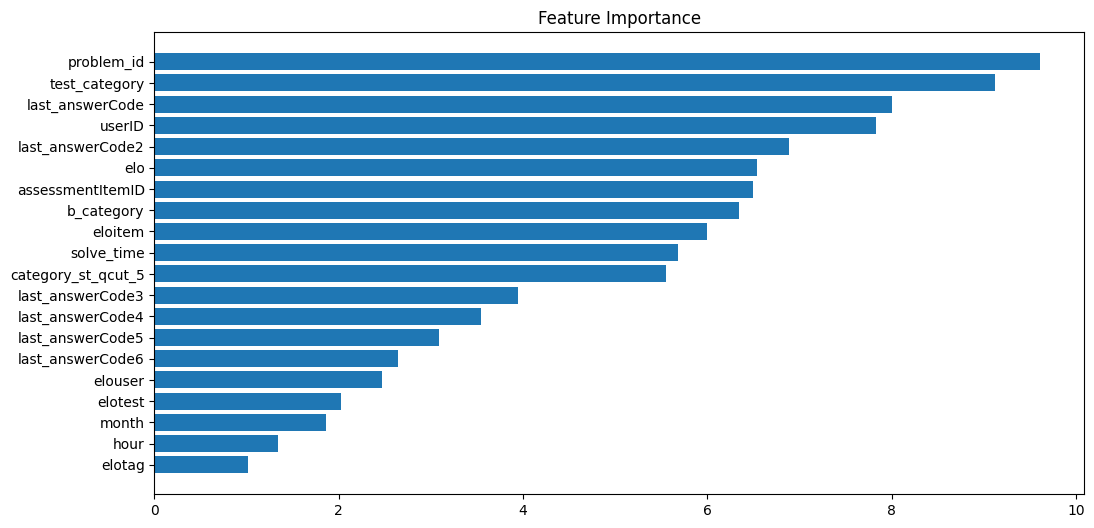

In [21]:
import matplotlib.pyplot as plt

feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), np.array(_valid.columns)[sorted_idx])
plt.title("Feature Importance")

In [20]:
#best param
param = {
    "task_type" : "GPU",
    "eval_metric" : 'AUC',
    "devices" : '0',
    'random_state' : 19991028,
    'learning_rate': 0.01,
    'iterations': 4000,
    'max_depth': 11,
    'od_type': 'Iter',
    "cat_features" : cat_columns,
    'bagging_temperature': 0.36391590193742546, 
    'random_strength': 9, 
    'l2_leaf_reg': 6.803149112111853e-06, 
    'min_child_samples': 93, 
    'max_bin': 237
    }
model = CatBoostClassifier(**param)
model.fit(_train, _train_value, early_stopping_rounds=1000, verbose=10, eval_set=(_valid, _valid_value))


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8025632	best: 0.8025632 (0)	total: 309ms	remaining: 20m 34s
10:	test: 0.8125623	best: 0.8125623 (10)	total: 3.21s	remaining: 19m 23s
20:	test: 0.8141282	best: 0.8141282 (20)	total: 6.02s	remaining: 19m 1s
30:	test: 0.8146618	best: 0.8146618 (30)	total: 8.78s	remaining: 18m 44s
40:	test: 0.8155831	best: 0.8156472 (39)	total: 11.6s	remaining: 18m 36s
50:	test: 0.8164927	best: 0.8164927 (50)	total: 14.2s	remaining: 18m 22s
60:	test: 0.8171308	best: 0.8171308 (60)	total: 17.2s	remaining: 18m 28s
70:	test: 0.8181202	best: 0.8181202 (70)	total: 20s	remaining: 18m 24s
80:	test: 0.8187015	best: 0.8187015 (80)	total: 22.6s	remaining: 18m 12s
90:	test: 0.8199134	best: 0.8199134 (90)	total: 25.4s	remaining: 18m 10s
100:	test: 0.8204771	best: 0.8204771 (100)	total: 28s	remaining: 18m 1s
110:	test: 0.8214818	best: 0.8214818 (110)	total: 30.6s	remaining: 17m 52s
120:	test: 0.8221007	best: 0.8221007 (120)	total: 33.3s	remaining: 17m 47s
130:	test: 0.8230713	best: 0.8230713 (130)	total: 36s

In [ ]:
print('train score')
test_pred = model.predict_proba(_train)[:,1]
print(roc_auc_score(_train_value, test_pred)) # auc
print(accuracy_score(_train_value, np.where(test_pred >= 0.5, 1, 0))) # acc, 정확도

print('valid score')
test_pred = model.predict_proba(_valid)[:,1]
print(roc_auc_score(_valid_value, test_pred)) # auc
print(accuracy_score(_valid_value, np.where(test_pred >= 0.5, 1, 0))) # acc, 정확도

In [ ]:
# submission 제출하기 위한 코드
test_pred = model.predict_proba(_test)[:,1]
_test['prediction'] = test_pred
submission = _test['prediction'].reset_index(drop = True).reset_index()
submission.rename(columns = {'index':'id'}, inplace = True)
submission.to_csv('../output/catrr.csv', index = False)